<a href="https://colab.research.google.com/github/SaxenaVaishnavi/Machine-Learning-Practices/blob/main/Week_6/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Over the past four weeks we explored  various  data preprocessing techniques and solved some regression problems using linear and logistic regression models.The other side of the supervised learning paradigm is classification problems.

To solve such problems we are going to consider image classification as a running example and solve it using `Perceptron()` model.
   
   

# Imports
What is the first step?
* Import all necessary packages. For classification problems, we need to import classes and utilities from `sklearn.linear_model`.  
  *  This module has implementations for different classification models like `Perceptron, LogisticRegression, svm` and `knn`
* We also need to import a bunch of model selection utilities from `sklearn.model_selection` module
* And metrics from `sklearn.metrics` module.
* The data preprocessing utilities are imported from `sklearn.preprocessing` modules.

In [83]:
# Common imports
import numpy as np
import os
import io
import warnings
from pprint import pprint

# sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer, roc_curve
from sklearn.model_selection import cross_validate, cross_val_predict,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Global matplotlib settings
mpl.rc('figure',figsize=(8,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To make this notebook's output stable across runs
np.random.seed(42)

Following definition helps us supress some warning messages. (**Warning:** we are purposefully supressing the warnings, not a good idea in general!).

In [2]:
# Ignore all warnings (like convergence..) by sklearn
def warn(*args, **kwargs):
    pass
warnings.warn = warn

#Handwritten Digit Classification

We are going to use **perceptron classifier** to classify (recognize) given digit images. Since a single perceptron could only be used for binary classification, we consider only two classes in the first half. Eventually we extend it to multi-class setting.

Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be cast as a binary classification problem.

The first step is to create a dataset that contains a collection of digit images (also called examples, samples) written by humans. Then each image should be labelled properly. We have a standard benchmark dataset called **MNIST** for this task.

## Data Loading and Splitting

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# It returns Data and label as a pandas dataframe

The data matrix $X$ and the respective label vector $y$ need to be converted to the numpy array by calling a `to_numpy` method.

In [4]:
X = X.to_numpy()
y = y.to_numpy()

Let's get some information like number of features, number of classes about the dataset.

Observe that the labels are of string data type not integers.

In [5]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum: {0}, Maximum: {1}'.format(np.min(X),np.max(X)))
print('Number of classes: {0}, type: {1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:int64
Number of features: 784
Minimum: 0, Maximum: 255
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


The MNIST dataset is clean and the range of values that each feature can take is also known. Therefore, the samples in the dataset may not require many data preprocessing techniques.

However, it is often better to scale the range of features between 0 to 1.

So, we can either use `MinMaxScaler` or `MaxAbsScaler`.They don't make any difference as the image pixels can take only positive values from 0 to 255.


In [6]:
X = MinMaxScaler().fit_transform(X)
print("Minimum: {0}, Maximum: {1}".format(np.min(X),np.max(X)))

Minimum: 0.0, Maximum: 1.0


## Data Visualization
Let us pick a few images (the images are already shuffled in the dataset) and display them with their respective labels. As said above, the images are stacked as a row vector of size $ 1 \times 784 $ and therefore must be reshaped to the matrix of size $ 28 \times 28 $  to display them properly.

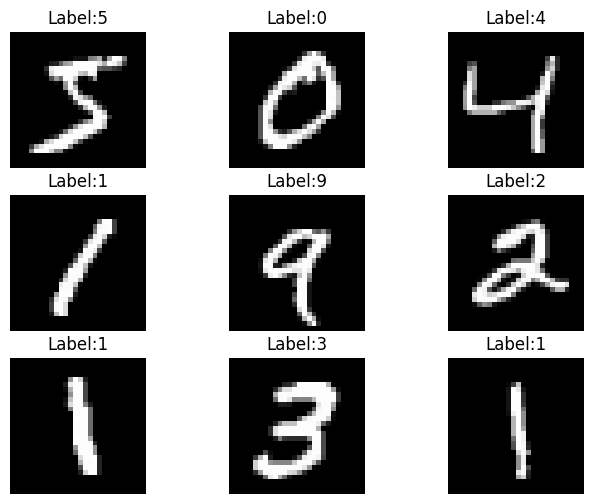

In [7]:
num_images = 9          # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0          # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

If you closely observe, you can see that there are moderate variations in the appearance of digits (say, digit: 1). These matrices are also close to sparse (that is, there are lot more 0s (black pixels) in the matrix than non-zero (white pixels)).

It is always a good practice to inspect the image pixel values closely and ask some interesting questions such as.

1.   What is the range of pixel values?
2.   Are the pixel values highly correlated?
3.   Is the data sparse?
4.   What is the range of values that a single pixel(element) can take?
5.   Do we need to apply any pre-processing methods?

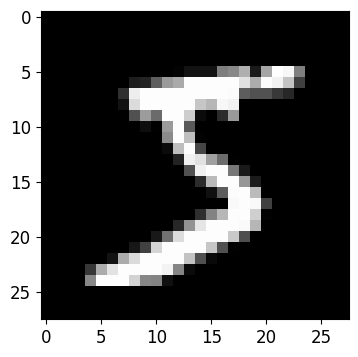

In [8]:
plt.figure(figsize=(4, 4))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

## Data Splitting

Now, we know the details such as number of samples, size of each sample, number of features (784), number of classes (targets) in the dataset.

Let us spilt the total number of samples into train and test set in the following ratio: $60,000/10,000$ (that is, $60,000$ samples in the training set and $10,000$ samples in the testing set).

**NOTE:** Since the samples in the data set are already randomly shuffled, we need **not to** shuffle it again. Therefore using `train_test_split()` may be skipped.

In [9]:
x_train,x_test,y_train,y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before procedding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.

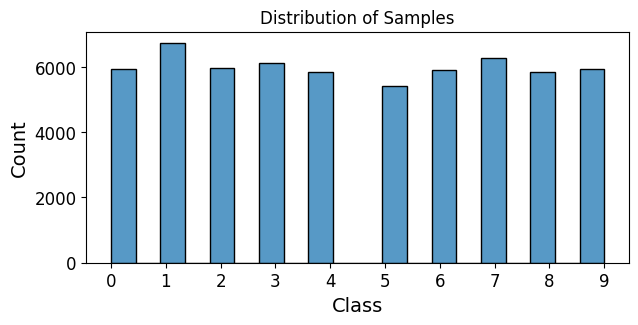

In [10]:
plt.figure(figsize=(7, 3))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

#Binary Classification : 0-Detector

## Modifying Labels
Let us start with a simple classification problem, that is, binary classification.
* Since the original label vector contains **10** classes, we need to modfiy the number of classes to **2**

* Therefore,  the label **0** will be changed to **1** and all other labels (1-9) will be changed to **-1**.

* We name the label vectors as `y_train_0` and `y_test_0 `.

In [11]:
# Intialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# Find indices of digit 0 image
# Remember original labels are of type str not int
indx_0 = np.where(y_train =='0')

# Use those indices to modify y_train_0 & y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

## Sanity check ⚛
Let's display the elements of `y_train` and `y_train_0` to verify whether the labels are properly modified. of course, we can't verify all the $60,000$ labels by inspection (unless we have a plenty of time or man power😀)

In [12]:
print(y_train)      # 10 class labels
print(y_train_0)    # modified binary labels

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [13]:
print(np.where(y_train == '0'))       # index of label 0's in original vector y
print(np.where(y_train_0 == 1))     # index of pos class in new vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


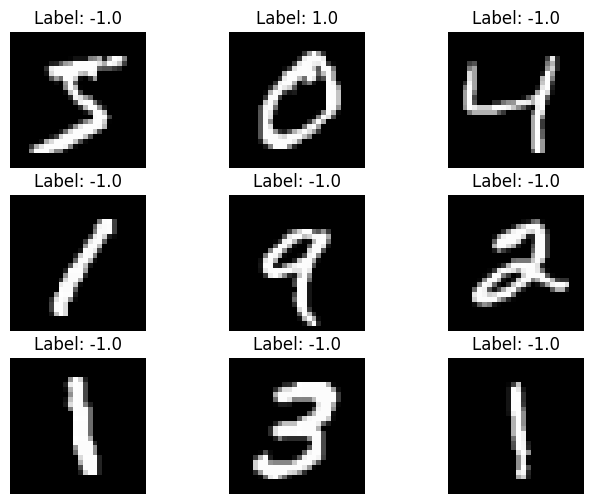

In [15]:
num_images = 9        # Choose a square number
factor = int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0                  # Take "num_images" starting from the index "idx_offset"

for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('Label: {0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

#Basline Models

  Enough about Data!
  
  Let us quickly construct a basline model with the following rule (you are free to a choose different rule) <br>

1.   Count number of samples per class.
2.   The model **always outputs** the class which has highest number of samples.
3.   Then calculate the accuracy of the basline model.

In [16]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg)

5923 54077


In [17]:
base_clf = DummyClassifier(strategy='most_frequent') # There are other strategies

In [18]:
base_clf.fit(x_train, y_train_0)
print('Training accuracy: {0:.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy: {0:.2f}'.format(base_clf.score(x_test, y_test_0)))

Training accuracy: 0.90
Testing accuracy: 0.90


Now the reason is obvious. The model would have predicted 54077 sample correctly just by outputing -1 for all the input samples.Therefore the accuracy will be $\frac{54077}{60000} = 90.12\%$.

This is the reason why "accuracy" alone is not always a good measure!.

#Perceptron model

 Before using Perceptron for Binary Classification, it will be helpful to recall the important concepts (equations) covered in MLT course.

## Recap (Theory)
Let us quickly recap various components in the general settings:
1.  **Training data**: (features, label) or $(\mathbf{X}, y)$, where label $y$ is a **discrete** number from a finite set.**Features** in this case are pixel values of an image.
2. **Model :** \begin{eqnarray}
  h_{\mathbf{w}}: y &=& \mathrm{g}(\mathbf{w}^T \mathbf{x}) \\
    &=& \mathrm{g}(w_0 + w_1 x_1 + \ldots + w_m x_m)
\end{eqnarray}
where,
  * $\mathbf{w}$ is a weight vector in $\mathbb{R}^{(m+1)}$ i.e. it has components: $\{w_0, w_1, \ldots, w_m\}$
  * $\mathrm{g}(.)$ is a non-linear activation function given by a signum function:
\begin{equation}
  \mathrm{g}(z) =\left\{
  \begin{array}{@{}ll@{}}
    +1, & \text{if}\ z \ge 0 \\
    -1, & \text{otherwise (i.e. } z < 0)
  \end{array}\right.
\end{equation}
3.**Loss function:**
Let $\widehat{y^{(i)}} \in \{-1, +1\}$ be the prediction from perceptron and $y^{(i)}$ be the actual label for $i$-th example.  The error is
\begin{equation}
  e^{(i)} =\left\{
  \begin{array}{@{}ll@{}}
    0, & \text{if}\ \widehat{y^{(i)}} = y^{(i)} \\
    -\mathbf{w}^T \mathbf{x}^{(i)}y^{(i)}, & \text{otherwise (i.e. }\widehat{y^{(i)}} \neq y^{(i)} )
  \end{array}\right.
\end{equation}

  This can be compactly written as:
\begin{equation}
  e^{(i)} = \mathrm{max}(-\mathbf{w}^T \mathbf{x}^{(i)}y^{(i)}, 0)
          = \mathrm{max}(-h_{\mathbf{w}}(\mathbf{x}^{(i)})y^{(i)}, 0)
\end{equation}
4.**Optimization:**
  * Perceptron learning algorithm
  
  1. Initialize $\mathbf{w}^{(0)} = \mathbf{0}$
  2. For each training example $\left(\mathbf{x}^{(i)}, y^{(i)} \right)$:
    * $\hat{y}^{(i)} = \mathrm{sign}\left(\mathbf{w}^T \mathbf{x}^{(i)}\right)$   [Calculate the output value]
    * $\mathbf{w}^{(t+1)} := \mathbf{w}^{(t)} + \alpha (y^{(i)} - \hat{y}^{(i)})\ \mathbf{x}^{(i)}$  [Update the weights]


Linearly separable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

## Parameters of Perceptron class
Let's quickly take a look into the important parameters of the `Perceptron()`

```python
class sklearn.linear_model.Perceptron(*, penalty=None, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001,
                                      shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, early_stopping=False,
                                      validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False).
```

Need not to pay attention to all the arguments and their default values.

Internally, the API uses the perceptron loss (i.e., the **Hinge(0.0)**, where $0.0$ is a threshold) and uses SGD to update the weights.

The other way of deploying perceptron is to use the genral  `linear_model.SGDClassifier` with `loss='perceptron'`

## Instantiation
Create an instantance of binary classifier `(bin_clf)`

In [19]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

## Training and Prediction

Call the `fit` method to train the model

It would be nice to plot the iteration vs loss curve for the training. However, sklearn does not have a direct function to plot it. Nevertheless, we can workaround this using `partial_fit` method (Which will be demonstrated at the end of the lecture)

In [31]:
bin_clf.fit(x_train,y_train_0)
print('Dimention of Weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias :{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss))

Dimention of Weights w: (1, 784)
Bias :[-108.]
The loss function: perceptron


Let us make  predictions on the train set and then calculate the training accuracy.

In [36]:
# y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: ', bin_clf.score(x_train, y_train_0))

Training Accuracy:  0.99095


Let us make the predictions on the test set and then calculate the testing accuracy.

In [37]:
print('Test accuracy: ', bin_clf.score(x_test, y_test_0))

Test accuracy:  0.989


## Displaying predictions
* Take few images from the testset at random and display it with the corresponding predictions.

* Plot a few images in a single figure window along with their respective **predictions**

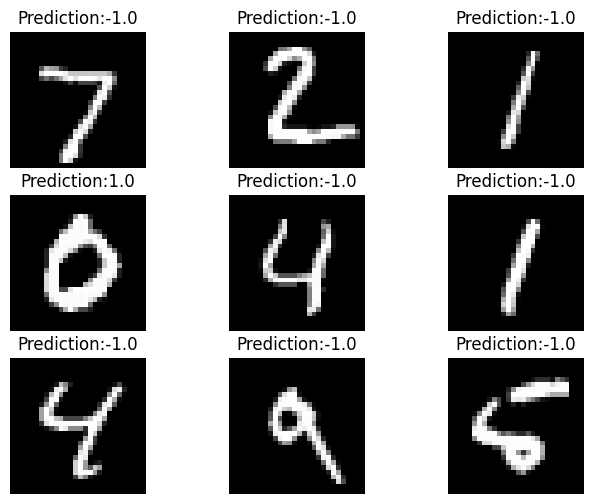

In [38]:
y_hat_test_0 = bin_clf.predict(x_test)

num_images = 9        # Choose a square number
factor = int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0        # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')        # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

Display images of positive classes from testset along with their predictions.

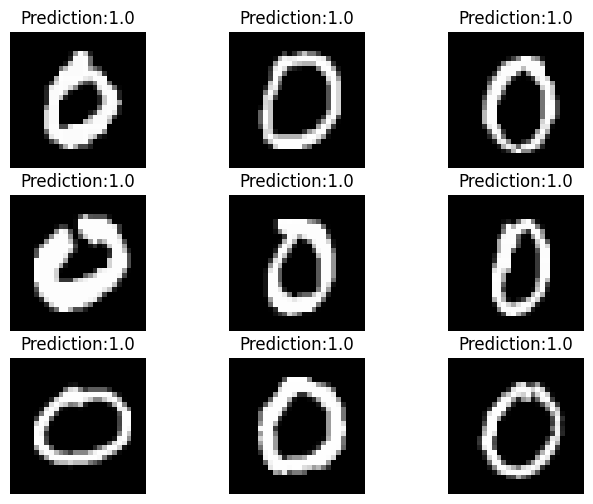

In [39]:
indx_0 = np.where(y_test_0 == 1)
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9          # Choose a square number
factor = int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0          # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

It seems that there are a significant number of images that are correctly classified. Let's see how many?

In [41]:
num_misclassified = np.count_nonzero(zeroLabls == -1)
num_correctpred = len(zeroLabls) - num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


This above score (guess the name of the metric) is less than the accuracy score of the model but it seems preety descent !.

Will it be the same if we consider an other digit, say, 5 for positive class and all other class as negative?..Of course not. You may cross check it. **(Take it as an exercise)**

# Better Evaluation metrics
We now know that using the accuracy **alone** to measure the performance of the model is not suitalbe (esspecially for imbalanced datasets)
So what are the more suitable metrics then?
   

## **Confusion Matrix**

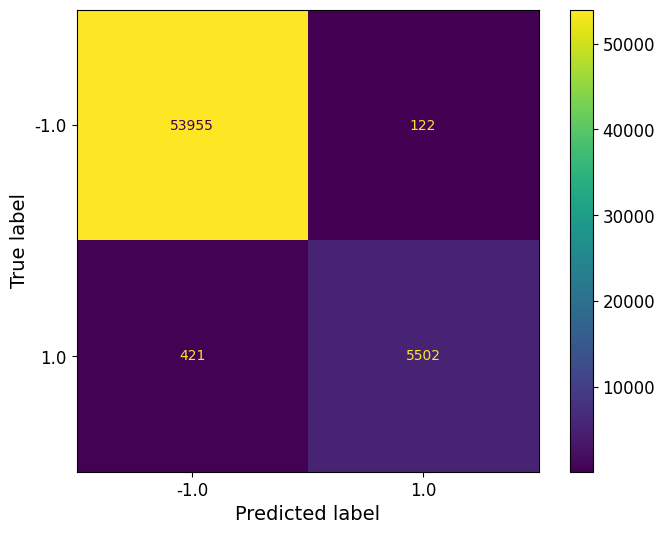

In [44]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g') # It return matplotlib plot object
plt.show()

Pay attention to the number of FPs and FNs. Suppose for some reasons, we want the classifier to avoid FPs to a good extent irrespective of FNs, how can we acheive it?.

To answer it, let's compute the other metrics which take FPs and FNs into account.

## Precision and Recall

We can use the function `classification_report` to compute these parameters. However, for the time being let's compute these parameters using the data from the confusion matrix manually  (Not a difficult thing to do, right 😀?).

In [45]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [46]:
precision = tp/(tp+fp)
print('Precision: ', precision)
recall = tp/(tp+fn)
print('Recall: ', recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: ', accuracy)

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


The precision is close to 0.98. Despite it, we still want to increase the precision.. Let's come back to this later.

In general, we would like to know whether the model under consideration with the set hyper-parameters is a good one for a given problem.

## Cross Validation
Well, to address this, we have to use cross-validation folds and measure the same metrics across these folds for different values of hyper-parameters. However, perceptron does not many hyperparameters other than the learning rate.

For the moment, we set the learning rate to its default value. Later, we use `GridSearchCV` to find the better value for the learning rate.

In [48]:
bin_clf = Perceptron(max_iter=100, random_state=1729)           # Repeating for readability
scores= cross_validate(bin_clf, x_train, y_train_0, cv=5,
                       scoring=['precision','recall','f1'],
                       return_estimator=True)
pprint(scores)                                                  # The json object is printed in different lines to make the output readable

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.20975399, 2.44865513, 1.5132463 , 1.35420227, 1.76227498]),
 'score_time': array([0.05219984, 0.02712393, 0.02575517, 0.02595496, 0.0478673 ]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


**Note:**  
* The perceptron estimator passed as an argument to the function `cross_validate` is internally cloned `num_fold (cv=5)` times and fitted independently on each fold. (you can check this by setting `warm_start=True`)
* Compute the average and standard deviation of scores for all three metrics on (k=5) folds to measure the generalization!.

In [49]:
print('f1 --        avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(),        scores['test_f1'].std()))
print('precision--  avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(), scores['test_precision'].std()))
print('recall--     avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(),    scores['test_recall'].std()))

f1 --        avg:0.94, std:0.013
precision--  avg:0.96, std:0.01
recall--     avg:0.92, std:0.03


Let us pick the first estimator returned by the cross-validate function.

So we can hope that the model might also perform well on test data. Let's check that out..

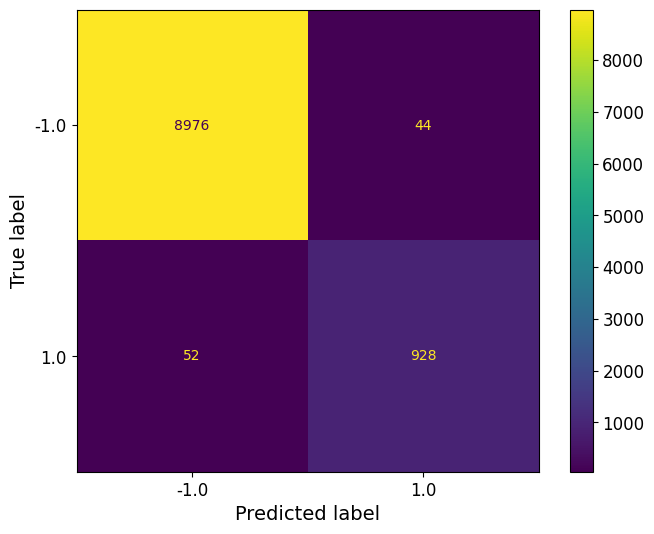

In [50]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')

In [51]:
print('Precision %.2f' %precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f' %recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


This is good!.

**Way-2 for Generalization:** <br> (Optional)
* There is an **another approach** of getting predicted labels via cross-validation and using it to measure the generalization.
* In this case, each sample in the dataset will be part of only one test set in the splited folds.

[Know more](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict)

In [ ]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv=5)

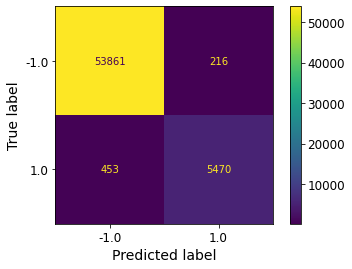

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g') # it return matplotlin plot object
plt.show()

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [ ]:
precision = tp/(tp+fp)
print('Precision: %.2f'%precision)
recall = tp/(tp+fn)
print('Recall:%.2f'%recall)
f1 = 2/((1/precision)+(1/recall))
print('f1:%.2f'%f1)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy: %.2f'%accuracy)


Precision: 0.96
Recall:0.92
f1:0.94
Accuracy: 0.99


* Compare the precision and recall score obtained by the above method with that of the previous method (i.e., using `cross_validate` )

* Finally, we can print all these scores as a report using the `classification_report `function

In [ ]:
print('Precision %.2f'%precision_score(y_train_0,y_hat_train_0))
print('Recall %.2f'%recall_score(y_train_0,y_hat_train_0))
print('-'*50)
print(classification_report(y_train_0,y_hat_train_0))

Precision 0.96
Recall 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Precision/Recall Tradeoff
Often we need to make a trade off between precision and recall scores of a model. It is important to note that we should **not** pass the **predicted labels** as input  to `precision_recall_curve` function, instead we need  to pass the probability scores or the output from the decision function!.

The `Perceptron()` class contains a `decision_function` method, therefore we can make use of it. Then, internaly the decision scores are sorted, **tps** and **fps** will be computed by changing the threshold from `index[0]` to `index[-1]`.

Let us compute the scores from the decision function.

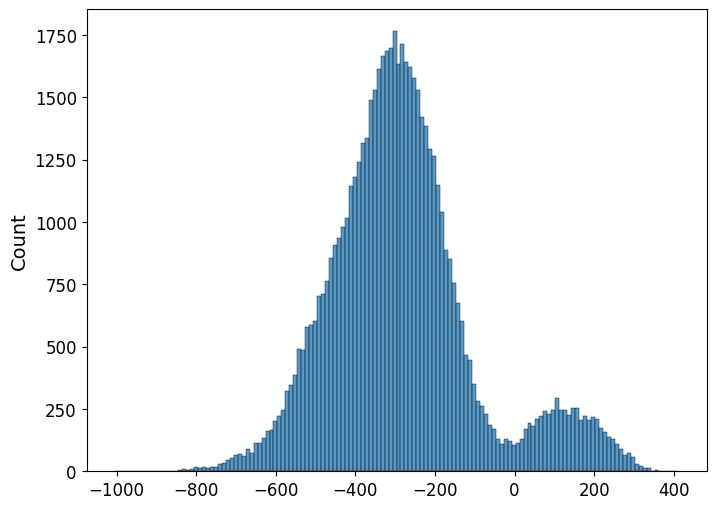

In [52]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

Can you think why there are so many negative values than the positives?. <br>
**Hint:** Class-Imbalance <br>
* Suppose threshold takes the value of -600,then all the samples having score greater than -600 is set to 1(Positive label) and less than it is set to -1 (neg label).
* Therefore, the number of False Positives will be increased. This will in turn reduce the precision score to a greater extent.

* On the otherhand, if the threshold takes the value of, say, 400. Then, the number of false negatives will be increase and hence the recall will reduce to a greater extent.

Let's see it in action.

In [53]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

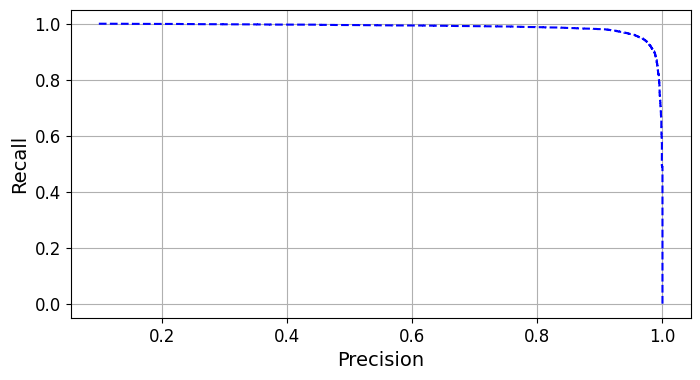

In [59]:
plt.figure(figsize=(8, 4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

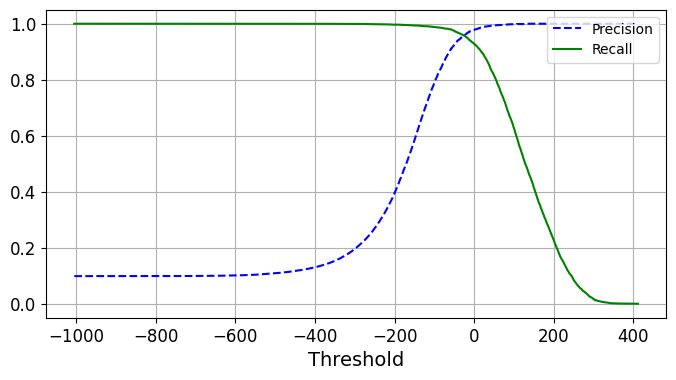

In [62]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [63]:
# Get the index of threshold around zero
idx_th = np.where(np.logical_and(thresholds>0, thresholds<1))
print('precision for zero thereshold:', precisions[idx_th[0][0]])

precision for zero thereshold: 0.9783072546230441


**Here is the solution** to the question how can we increase the precision of the classifier by compromising the recall. we can make use of the above plot. Let's see how.

In [64]:
def predict(y_scores):
  y_hat = np.where(y_scores>20, 1, -1)        # Shifted signum function
  return y_hat

In [65]:
y_hat_train_0_thrsh = predict(y_scores)
print(classification_report(y_train_0, y_hat_train_0_thrsh))


              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.99      0.90      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.95      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## The ROC Curve

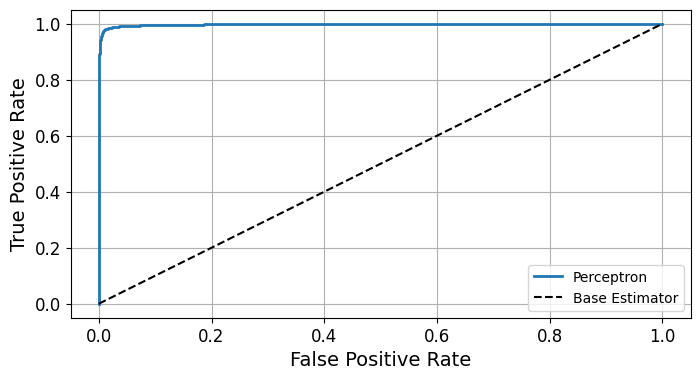

In [70]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, linewidth=2, label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--', label='Base Estimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

# Warm start vs Cold Start


## Cold Start
If we execute the `fit` method of `bin_clf` repeatedly, we get the same score for both training and testing accuracy. This because every time the` fit `method is called, the model weights are initialized to the same values. Therfore, we obtain the same score. This is termed as **cold start**. Let's execute the following cell 4 times and observe the score.

In [76]:
bin_clf.fit(x_train, y_train_0)
print('Training Accuracy:', bin_clf.score(x_train, y_train_0))
print('Test accuracy: ', bin_clf.score(x_test, y_test_0))

Training Accuracy: 0.99095
Test accuracy:  0.989


## Warm Start
There is an approach called `Warm Start`. Setting `warm_start=True` retains the weight values of the model after `max_iter` and hence produce different results for each execution.

Warm starting is  useful in many ways.
* It helps us train the model by initializing the weight values from the previous state. So we can pause the training and resume it whenever we get the resource for computation.

* Of course, it is not required for simple models like perceptron and for a small dataset like MNIST.

* In this notebook, we use this feature to plot the `iteration vs loss` curve.

Let us execute the following lines of code 4 times and observe how the training accuracy changes for each execution.

In [75]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True)

In [82]:
bin_clf_warm.fit(x_train,y_train_0)
print('Training Accuracy:', bin_clf_warm.score(x_train, y_train_0))

Training Accuracy: 0.9919


# Multiclass Classifier (OneVsAll)

We know that the perceptron is a binary classifier. However, MNIST dataset contains 10 classes. Then how can we extend the idea to handle multi-class problems?

**Solution:** Combine multiple binary classifiers and devise a suitable scoring metric.

Sklearn makes it extremely easy without modifying a single line of code that we have written for the binary classifier.

Sklearn does this by counting a number of unique elements (10 in this case) in the label vector `y_train ` and converting labels  using `LabelBinarizer`to fit each binary classifer (Remember binary classifier requires binary labels, Tautology :-))

That's all!

In [84]:
clf = Perceptron(random_state=1729)

In [85]:
# Let's use label binarizer just to see the encoding
y_train_ovr = LabelBinarizer().fit_transform(y_train)   # Setting sparse_output=True in LabelBinarizer() improves efficiency
for i in range(10):
  print('{0}:{1}'.format(y_train[i], y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


The `y_train_ovr` will be of size of size $60000 \times 10$.

The first column will be a (binary) label vector for 0-detector 😀 and the next one for 1-Detector and so on.


In [86]:
clf.fit(x_train, y_train)

Perceptron(random_state=1729)

What had actually happened internally was that
* the API automatically created 10 binary classifiers
* converted labels to binary sparse matrix
* trained them with the binarized labels.

During the inference time, the input will be passed through all these 10 classifiers and the highest score among the ouput from the classifiers will be considered as the predicted class.

To see it in action, let us execute the following lines of code

In [87]:
print('Shape of Weight matrix:{0} and bias vector:{1}'.format(clf.coef_.shape, clf.intercept_.shape))

Shape of Weight matrix:(10, 784) and bias vector:(10,)


So it is a matrix of size $10 \times 784$ where each row represents the weights for a single binary classifier.

Important difference to note is that there is no signum function associated with the perceptron.

In [91]:
scores = clf.decision_function(x_train[6].reshape(1,-1))
print(scores)
print()
print('The predicted class: ', np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]

The predicted class:  1


In [97]:
print('Preicted output:')
print(clf.predict(x_train[0].reshape(1,-1)))
print(clf.predict(x_train[6].reshape(1,-1)))

Preicted output:
['5']
['1']


In [98]:
# Get the prediction for all training samples
y_hat = clf.predict(x_train)

In [99]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



Let us display the confusion matrix and relate it with the report above.

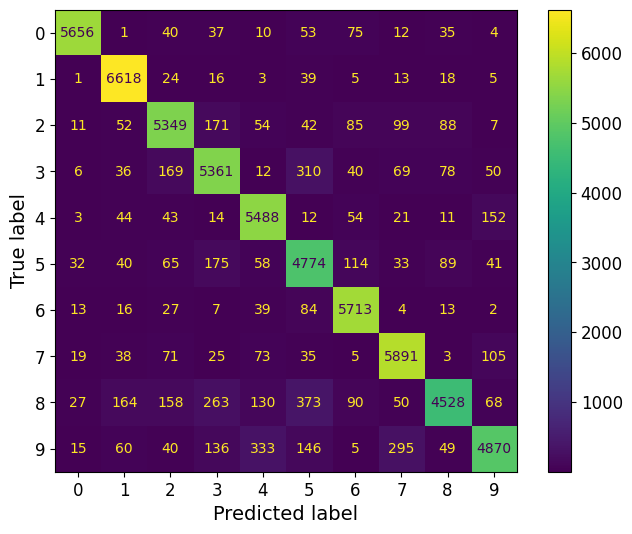

In [100]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat, values_format='.5g')

What are all the insights we could infer from the above figure?
* Digit 2 is often confused with Digit 3 (Reasonable!).

# Making a Pipeline

Let's create a pipline to keep the code compact. Recall that, the MNIST dataset is clean and hence doesn't require much preprocessing. The one potential preprocessing technique we may use is to scale the features within the range (0,1)

It is **not** similar to scaling down the range values between 0 and 1.

In [104]:
pipe = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('bin_clf', Perceptron())
])

pipe.fit(x_train, y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

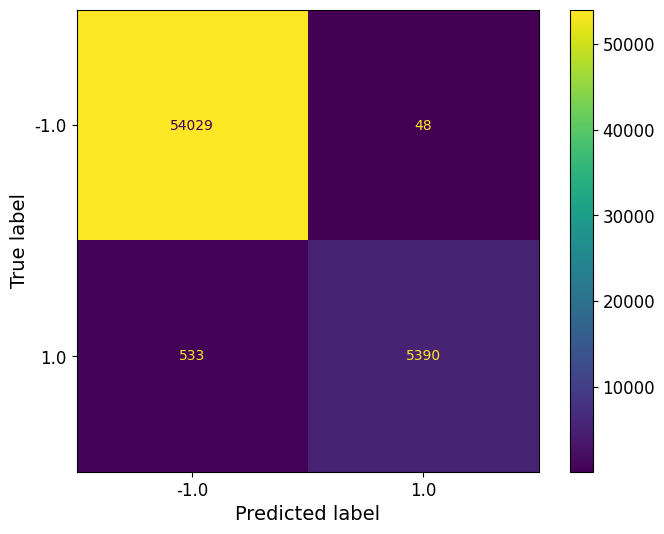

In [105]:
y_hat_train_0 = pipe.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

# Iteration vs Loss Curve
The other way of plotting **Iteration vs Loss** curve is with the `Partial_fit` method.

In [106]:
iterations = 100
bin_clf1 = Perceptron(max_iter=1000, random_state=2094)
Loss_clf1 = []

for i in range(iterations):
  bin_clf1.partial_fit(x_train, y_train_0, classes=np.array([1,-1]))
  y_hat_0 = bin_clf1.decision_function(x_train)
  Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

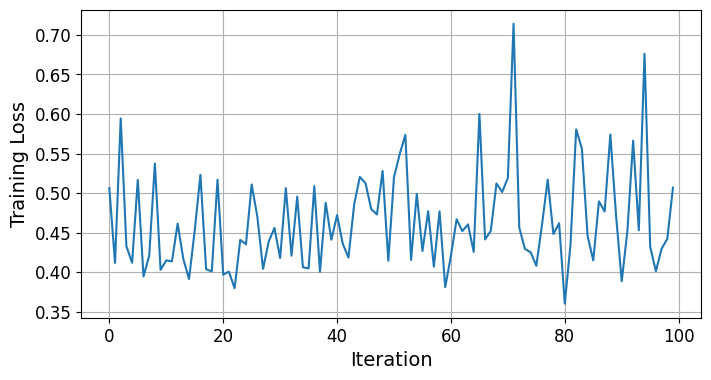

In [115]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

# GridSearchCV

So far we didn't do any hyperparameter tuning. We accepted the default value for learning rate of the Perceptron class.

Now, let us search for a better learning rate using `GridSearchCV`. No matter what the learning rate is, the loss will never converge to zero as the claases are not linearly separable.

In [117]:
scoring = make_scorer(hinge_loss, greater_is_better=False)
param_grid = {'eta0': [1/2**n for n in range(1, 6)]}
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid, scoring=scoring, cv=5)
bin_clf_gscv.fit(x_train,y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False, response_method='predict'))

As you can see, the best learning rate is 0.125.

In [119]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.26200032, 1.17242646, 1.19159946, 0.9452034 , 0.93538074]),
 'mean_score_time': array([0.02534947, 0.01643791, 0.01973181, 0.0176518 , 0.02368631]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value=1e+20),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5], dtype=int32),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.04416667]),
 'split4_tes

In [120]:
iterations = 100
Loss = []
best_bin_clf = Perceptron(max_iter=1000 ,random_state=2094, eta0=0.125)

for i in range(iterations):
  best_bin_clf.partial_fit(x_train, y_train_0, classes=np.array([1,-1]))
  y_hat_0 = best_bin_clf.decision_function(x_train)
  Loss.append(hinge_loss(y_train_0, y_hat_0))

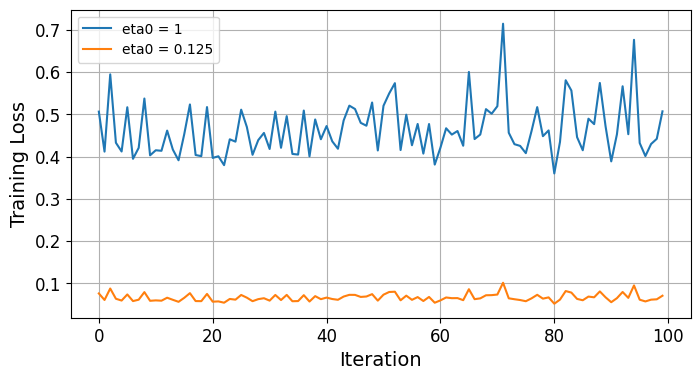

In [121]:
plt.figure(figsize = (8, 4))
plt.plot(np.arange(iterations), Loss_clf1, label='eta0 = 1')
plt.plot(np.arange(iterations), Loss, label='eta0 = 0.125')
plt.grid(True)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

Well, instead of instatiating a Perceptron class with a new learning rate and re-train the model, we  could simply get the best_estimator from `GridSearchCV` as follows and use it for predictions.

In [126]:
best_bin_clf = bin_clf_gscv.best_estimator_
y_hat_train_0 = best_bin_clf.predict(x_train)
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99     54077
         1.0       0.95      0.95      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Compare the classification report when `eta0=1`

# Visualizing weight vectors (Optional)
  It will be interesting to look into the samples which are misclassified as False Positives (that is, images that are not zero but classified as zero),   and come up with some possible reasons. Shall we do it?

In [ ]:
# repeating the code for readabilituy
bin_clf = Perceptron(max_iter=100)
bin_clf.fit(x_train,y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)

In [ ]:
#find the index of false positive samples
idx_n = np.where(y_train_0 ==-1) # index of true -ve samples
idx_pred_p = np.where(y_hat_train_0==1) # index of predicted positive samples
idx_pred_n = np.where(y_hat_train_0==-1) # index of predicted negative samples
idx_fp = np.intersect1d(idx_n,idx_pred_p)
idx_tn = np.intersect1d(idx_n,idx_pred_n)

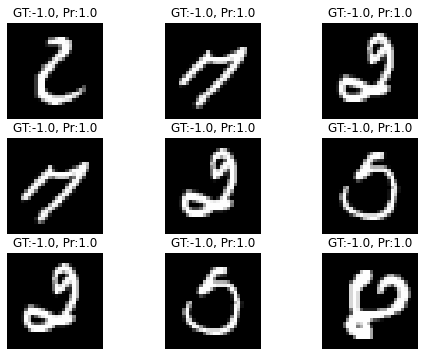

In [ ]:
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0
for i in range(3):
  index = idx_offset+i
  for j in range(3):
    ax[i,j].imshow(x_train[idx_fp[index+j]].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('GT:{0}, Pr:{1}'.format(str(y_train_0[idx_fp[index+j]]),str(y_hat_train_0[idx_fp[index+j]])))
    ax[i,j].set_axis_off()

 We can do some reasoning if we look into what the perceptron is actually learning about the digit **0** by visualizing the weight values after the training.!

In [ ]:
from matplotlib.colors import Normalize

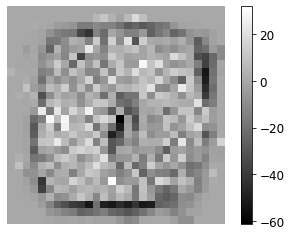

In [ ]:
w = bin_clf.coef_
w_matrix = w.reshape(28,28)
fig = plt.figure()
plt.imshow(w_matrix,cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

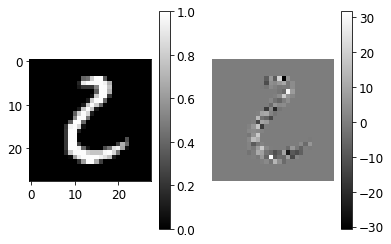

In [ ]:
activation = w * x_train[idx_fp[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_fp[0]].reshape(28,28),cmap='gray')
plt.colorbar()
# lin_out[lin_out<0]=0 #just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out,cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
#input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)

[22.90520569]


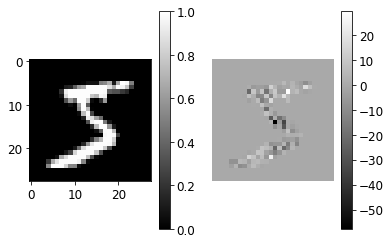

In [ ]:
activation = w*x_train[idx_tn[0]].reshape(1,-1)
lin_out = activation.reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(x_train[idx_tn[0]].reshape(28,28),cmap='gray')
plt.colorbar()
# lin_out[lin_out<0]=0 #just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out,cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [ ]:
#input to signum
print(np.sum(lin_out) + bin_clf.intercept_)

[-293.33960784]
